In [1]:
import requests 
import csv
import os 
import time

api_url = 'https://www.alphavantage.co/query'
api_key = os.environ['ALPHA_ADVANTAGE']
params = {'function':'TIME_SERIES_DAILY_ADJUSTED',
              'outputsize':'full',
              'datatype':'csv',
             'apikey': api_key}

def download_data_full(symbol):
    '''
    download the full-length time series of 
    up to 20 years of historical data for a symbol
    '''
    params['symbol'] = symbol    #add one more variable parameter to symbol

    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        data = response.content.decode('utf-8')
    else:
        print('[!] HTTP {0} calling [{1}]'.format(response.status_code, api_url))
    result = [data.split(',') for data in data.split('\r\n')]
    return result 

with open("nasdaqlisted.txt", 'r') as f:
    stock_listed = f.read()


for line in stock_listed.split("\n")[1:2]:   #download only the 1st stock in nasdaqlisted.txt
    symbol = line.split("|")[0]
    print("Downloading {}".format(symbol))
    try:
        result = download_data_full(symbol)
        with open("prices/{}_daily_adjusted.csv".format(symbol.lower()), "w+") as f:
            writer = csv.writer(f)
            writer.writerows(result)
    except Exception as e:
        print(e)
    time.sleep(1)

# Histogram of size of files in folder

(array([   1.,    0.,    0.,    1.,  169.,  104.,  121.,  104.,   54.,    7.]),
 array([  45405. ,   57323.3,   69241.6,   81159.9,   93078.2,  104996.5,
         116914.8,  128833.1,  140751.4,  152669.7,  164588. ]),
 <a list of 10 Patch objects>)

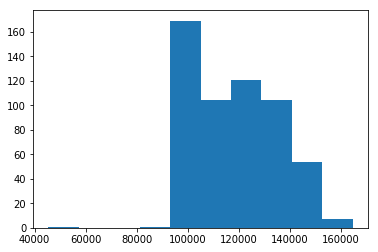

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

sizes = []
for i in os.listdir('prices'):
    sizes.append(os.path.getsize("prices/{}".format(i)))
plt.hist(sizes,bins =10)

# Time taken to read without multithread 2.2-3.2 seconds

In [3]:
import time

class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = hash(key)%self.size
        for k,v in self.array[ind]:
            if key == k:
                return v
    
    def __setitem__(self, key, value):
        ind = hash(key)%self.size
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        replace = None
        for i,data in enumerate(self.array[ind]):
            if data[0] == key:
                replace = i
        if replace is None:
            self.array[ind].append((key,value))
        else:
            self.array[ind][replace] = (key, value)
            
hash_table = HashTable(561)
directory = "prices"

def run():
    
    start = time.time()
    for filename in os.listdir(directory):
        key = filename.replace(".csv", "")
        with open("prices/{}".format(filename)) as f:
            data = f.read().split("\n")[1:]  #to remove header
            neat_data = [item.split(',') for item in data]
            
            hash_table[key] = neat_data
    return time.time()-start

times = []

for i in range(10):
        print(i)
        times.append(run())

0
1
2
3
4
5
6
7
8
9


(array([ 2.,  1.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2.05429983,  2.15092986,  2.24755988,  2.34418991,  2.44081993,
         2.53744996,  2.63407998,  2.73071001,  2.82734003,  2.92397006,
         3.02060008]),
 <a list of 10 Patch objects>)

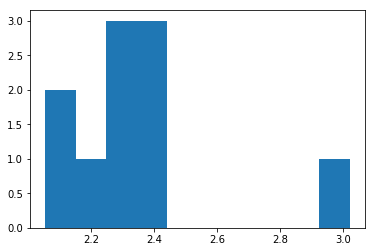

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(times)

## Time taken to read with multithread (2 worker)  up to 0.03 secs , a 100x improvement 

(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([ 0.        ,  0.00156002,  0.00312004,  0.00468006,  0.00624008,
         0.0078001 ,  0.00936012,  0.01092014,  0.01248016,  0.01404018,
         0.0156002 ]),
 <a list of 10 Patch objects>)

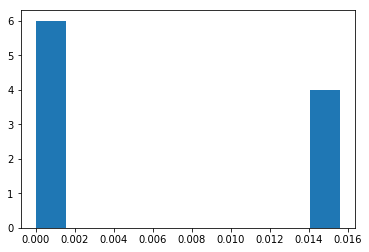

In [5]:
import concurrent.futures
import numpy as np

class HashTable():
    
    def __init__(self, size):
        self.array = np.zeros(size, dtype=np.object)
        self.size = size
    
    def __getitem__(self, key):
        ind = hash(key)%self.size
        for k,v in self.array[ind]:
            if key == k:
                return v
    
    def __setitem__(self, key, value):
        ind = hash(key)%self.size
        if not isinstance(self.array[ind], list):
            self.array[ind] = []
        replace = None
        for i,data in enumerate(self.array[ind]):
            if data[0] == key:
                replace = i
        if replace is None:
            self.array[ind].append((key,value))
        else:
            self.array[ind][replace] = (key, value)
            
hash_table2 = HashTable(561)
directory = "prices"



filenames = [filename for filename in os.listdir(directory)]

def read_files(filename):
    key = filename.replace(".csv", "")
    with open("prices/{}".format(filename)) as f:
        data = f.read().split("\n")[1:]  #to remove header
        neat_data = [item.split(',') for item in data]
        
        hash_table2[key] = neat_data
        
        
pool = concurrent.futures.ThreadPoolExecutor(max_workers=2)

def run_pool():
    start = time.time()
    pool.map(read_files, filenames)
    return time.time()-start

    
times_pool = []

for i in range(10):
        times_pool.append(run_pool())
        
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(times_pool,bins=10)